# BERLIN GENTRIFICATION

## Prelimiaries

### Import dependencies

In [3]:
import shapefile

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sbn

from matplotlib.patches  import Polygon
from matplotlib.colors   import ListedColormap, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from sklearn             import cluster, metrics

%matplotlib notebook

### Define some functions
Read a time series of files into a dataframe

In [4]:
def read_from_csv(path, prefix, suffix, period):
    file = path + prefix + str(period[0]) + suffix + '.csv'
    
    data = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1')
    data.ZEIT = period[0]
    data.sort_values('RAUMID', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    years = range(period[0] + 1, period[1] + 1)

    for year in years:
        file = path + prefix + str(year) + suffix + '.csv'
    
        year_data = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1')
        year_data.ZEIT = year
        year_data.sort_values('RAUMID', inplace=True)
        year_data.reset_index(drop=True, inplace=True)
        year_data.columns = data.columns
    
        data = data.append(year_data)

    data.drop(['BEZ', 'PGR', 'BZR', 'PLR', 'STADTRAUM'], axis=1, inplace=True)
    data.rename(columns={'ZEIT':'Year', 'HK_EU28':'HK_EU27', 'RAUMID':'LOR'}, inplace=True)
    data = data.astype(int)
    data.set_index(['LOR', 'Year'], inplace=True)
    data.sort_index(level='LOR', inplace=True)
    
    return data

Create a multi-index from a simple index and a title

In [5]:
def titled_columns(df, title):
    return pd.MultiIndex(levels=[[title], df.columns],
                         labels=[[0 for x in df.columns],
                                 [x for x in range(df.columns.size)]])

Compute distance between two LORs from an $L_2$ norm suitable for our case 

In [6]:
def distanceL2(df1, df2, measure):
    diff = df1 - df2  
    result = np.square(diff).sum().dot(measure)
    return np.sqrt(result)

Compute a distance matrix on the whole data set using our $L_2$ distance

In [7]:
def pairwise_distanceL2(df, measure):
    n = df.index.levshape[0]
    result = np.zeros((n ,n))
    for row in range(n):
        for col in range(n):
            lor_row = df.index.levels[0][row]
            lor_col = df.index.levels[0][col]
            result[row, col] = distanceL2(df.loc[lor_row], df.loc[lor_col], measure)
    return result

## Read Datasets
Set time span and path to data here:

In [8]:
minyear = 2007 # no data available before 2007!
maxyear = 2015 # no data available after 2015!
path = './data/people/'

period = (minyear, maxyear)

del minyear
del maxyear

Read from file and generate set for non-migrants

In [9]:
mb  = read_from_csv(path, 'EWRMIGRA', '12E_Matrix', period)
org = read_from_csv(path, 'EWRMIGRA', '12H_Matrix', period)
age = read_from_csv(path, 'EWR',      '12E_Matrix', period)
dur = read_from_csv(path, 'WHNDAUER', '_Matrix',    period)
typ = read_from_csv(path, 'WHNLAGE',  '_Matrix',    period)

lors = shapefile.Reader('./data/geo/RBS_OD_LOR_2015_12')

del period
del path

### Fix inconsitencies in data
There are 3 more people in the age statistics than in the type-of-housing statistics for two LORs (*9031001* and *10040828*) in 2007. We will add the missing three to the NZORD column of the housing statistics.

In [10]:
if 2007 in typ.index.levels[1]:
    typ.loc[9031001,  2007].WLNZORD += 3
    typ.loc[10040828, 2007].WLNZORD += 3

The ordering of the rows of the migration-background-by-origin dataset is wrong in 2014 for district 7. We are going to re-shuffle by matching on the total number of folks with migration background, which is correct (or, at least, not inconsistent) in the migration-background-by-age data.

In [11]:
if 2014 in org.index.levels[1]:
    wrong = org[(mb.MH_E - org.MH_E) != 0]
    right =  mb[(mb.MH_E - org.MH_E) != 0]

    for index in right.index:
        org.loc[index] = wrong[wrong.MH_E == right.loc[index].MH_E].values

    del wrong
    del right
    del index

### Preprocess data sets

In [12]:
dur.insert(loc=2, column='5to10', value=(dur['DAU5'] - dur['DAU10']))
dur.insert(loc=2, column='lt5', value=(age['E_E'] - dur['DAU5']))
dur.drop(['EINW10', 'EINW5', 'DAU5', 'PDAU10', 'PDAU5'], axis=1, inplace=True)
dur.rename(columns={'DAU10':'gt10'}, inplace=True)

org.insert(loc=2, column='HK_EUost', value=(org['HK_EU27'] - org['HK_EU15'] - org['HK_Polen']))
org.drop(['HK_EU27'], axis=1, inplace=True)
org.MH_E = age['E_E'] - mb['MH_E']
org.rename(columns={'MH_E':'De'}, inplace=True)
new_col_names = pd.Index([column[3:] for column in org.columns[1:]])
org.columns = org.columns[:1].append(new_col_names)

tot = age['E_E']
age.drop('E_E', axis=1, inplace=True)
age.drop(age.columns[-9:], axis=1, inplace=True)
age.columns = pd.Index([column[3:].replace('_', 'to').lower() for column in age.columns])

typ.columns = pd.Index([column[2:] for column in typ.columns])
typ.rename(columns={'EINFol':'EINFoL', 'NZORD':'NZOrd'}, inplace=True)

sex = age.loc[:, :'w'].copy()
age.drop(['m', 'w'], axis=1, inplace=True)

del new_col_names
del mb
del tot

### Save $L_1$-normalized data for later

In [13]:
l1_norm_sex = sex.apply(lambda x: x / x.sum(), axis=1)
l1_norm_org = org.apply(lambda x: x / x.sum(), axis=1)
l1_norm_typ = typ.apply(lambda x: x / x.sum(), axis=1)
l1_norm_age = age.apply(lambda x: x / x.sum(), axis=1)
l1_norm_dur = dur.apply(lambda x: x / x.sum(), axis=1)

de_norm_org = l1_norm_org.De.copy()
l1_norm_org.De = 0.0

l1_norm_dur.columns = titled_columns(l1_norm_dur, 'dur')
l1_norm_org.columns = titled_columns(l1_norm_org, 'org')
l1_norm_age.columns = titled_columns(l1_norm_age, 'age')
l1_norm_typ.columns = titled_columns(l1_norm_typ, 'typ')
l1_norm_sex.columns = titled_columns(l1_norm_sex, 'sex')

l1_norm_dat = l1_norm_sex.join(l1_norm_age).join(l1_norm_org).join(l1_norm_dur).join(l1_norm_typ)

del l1_norm_dur
del l1_norm_org
del l1_norm_age
del l1_norm_typ
del l1_norm_sex

## Center and Normalize Data

Extract time intervals for the square integration of, in particular, the dur(ation) and age data

In [14]:
delta_sex = [1.0 for x in range(sex.shape[1])]
delta_typ = [1.0 for x in range(typ.shape[1])]
delta_org = [1.0 for x in range(org.shape[1])]
delta_dur = [1.0/5.0, 1.0/5.0, 1.0/100.0]
delta_age = []

for interval in age.columns.copy():
    delta = int(interval.split(sep='to')[1]) - int(interval.split(sep='to')[0])
    delta_age.append(1.0 / delta)

measure = delta_sex + delta_age + delta_org + delta_dur + delta_typ
    
del interval
del delta

Determine mean values for each year and category

In [15]:
mean_sex = sex.sum(axis=1) / sex.shape[1]
mean_typ = typ.sum(axis=1) / typ.shape[1]
mean_org = org.sum(axis=1) / org.shape[1]
mean_dur = dur.sum(axis=1) / 110
mean_age = age.sum(axis=1) / 110

Subtract respective mean values from data

In [16]:
dur = dur.apply(lambda x: x - pd.Series([mean_dur.loc[x.name[0], x.name[1]]] * dur.shape[1]).divide(delta_dur).values, axis=1)
org = org.apply(lambda x: x - pd.Series([mean_org.loc[x.name[0], x.name[1]]] * org.shape[1]).divide(delta_org).values, axis=1)
age = age.apply(lambda x: x - pd.Series([mean_age.loc[x.name[0], x.name[1]]] * age.shape[1]).divide(delta_age).values, axis=1)
typ = typ.apply(lambda x: x - pd.Series([mean_typ.loc[x.name[0], x.name[1]]] * typ.shape[1]).divide(delta_typ).values, axis=1)
sex = sex.apply(lambda x: x - pd.Series([mean_sex.loc[x.name[0], x.name[1]]] * sex.shape[1]).divide(delta_sex).values, axis=1)

del mean_sex
del mean_typ
del mean_age
del mean_dur
del mean_org

Compute appropriate $L_2$ normalization constant for each category and year

In [17]:
norm_sex = np.sqrt(np.square(sex).apply(lambda x: x.dot(delta_sex), axis=1))
norm_typ = np.sqrt(np.square(typ).apply(lambda x: x.dot(delta_typ), axis=1))
norm_age = np.sqrt(np.square(age).apply(lambda x: x.dot(delta_age), axis=1))
norm_dur = np.sqrt(np.square(dur).apply(lambda x: x.dot(delta_dur), axis=1))
norm_org = np.sqrt(np.square(org).apply(lambda x: x.dot(delta_org), axis=1))

del delta_sex
del delta_typ
del delta_age
del delta_dur
del delta_org

Divide data by the corresponding normalization constant

In [18]:
dur = dur.apply(lambda x: x / norm_dur.loc[x.name[0], x.name[1]], axis=1)
org = org.apply(lambda x: x / norm_org.loc[x.name[0], x.name[1]], axis=1)
age = age.apply(lambda x: x / norm_age.loc[x.name[0], x.name[1]], axis=1)
typ = typ.apply(lambda x: x / norm_typ.loc[x.name[0], x.name[1]], axis=1)
sex = sex.apply(lambda x: x / norm_sex.loc[x.name[0], x.name[1]], axis=1)

del norm_sex
del norm_typ
del norm_age
del norm_dur
del norm_org

Merge data

In [19]:
dur.columns = titled_columns(dur, 'dur')
org.columns = titled_columns(org, 'org')
age.columns = titled_columns(age, 'age')
typ.columns = titled_columns(typ, 'typ')
sex.columns = titled_columns(sex, 'sex')

data = sex.join(age).join(org).join(dur).join(typ)

del dur
del org
del age
del typ
del sex

## Analyze Data by Clustering

### Custom distance matrix
#### Compute $L_2$ distance matrix between LORs

In [20]:
dist_mat = pairwise_distanceL2(data, measure)

#### Save computed distance matrix to disk

In [21]:
save_data = pd.DataFrame(data=dist_mat, index=data.index.levels[0], columns=data.index.levels[0])
save_data.to_csv('./distance_matrix.csv')

#### Read pre-computed distance matrix from disk

In [22]:
dist_mat = pd.read_csv('./distance_matrix.csv')
dist_mat.set_index(['LOR'], inplace=True) 

### Graphically inspect distance matrix
**Note**: If you are using the just-computed distance matrix instead of the precomputed one from disk, delete the _values_ from the first argument of the plotting-function call on the second line below!

<IPython.core.display.Javascript object>


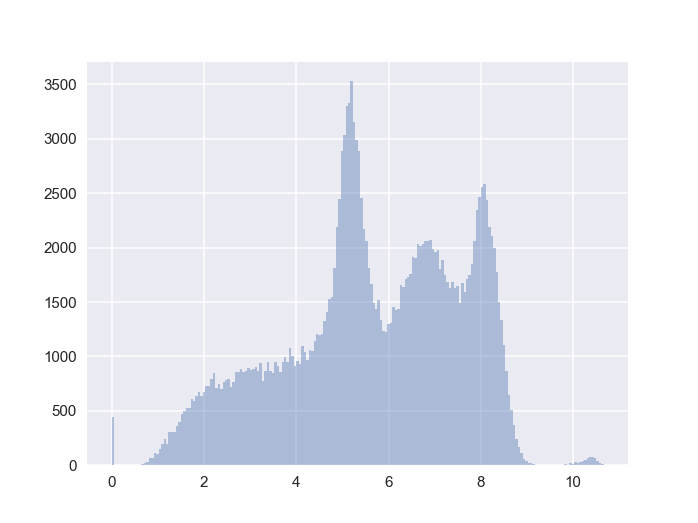

In [23]:
fig, ax = plt.subplots(num='Histogram of the Distances between LORs')

sbn.distplot(dist_mat.values.flatten(), bins=200, kde=False, ax=ax);

### OPTION 1: Agglomerative Clustering

In [24]:
n_clust = 15  # The number of clusters we are starting our search with

score = []

You can try either _average_ or _complete_ option for the _linkage_ keyword below. Then repeatedly execute the cell to increase the number of clusters!

<IPython.core.display.Javascript object>


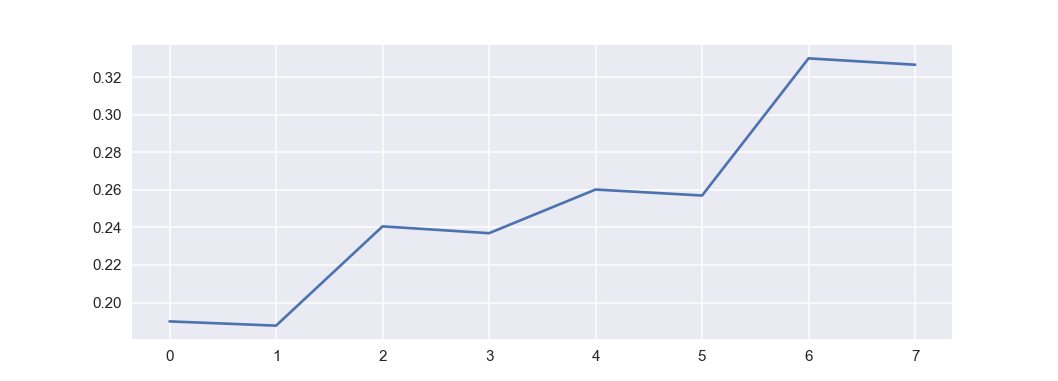

<IPython.core.display.Javascript object>


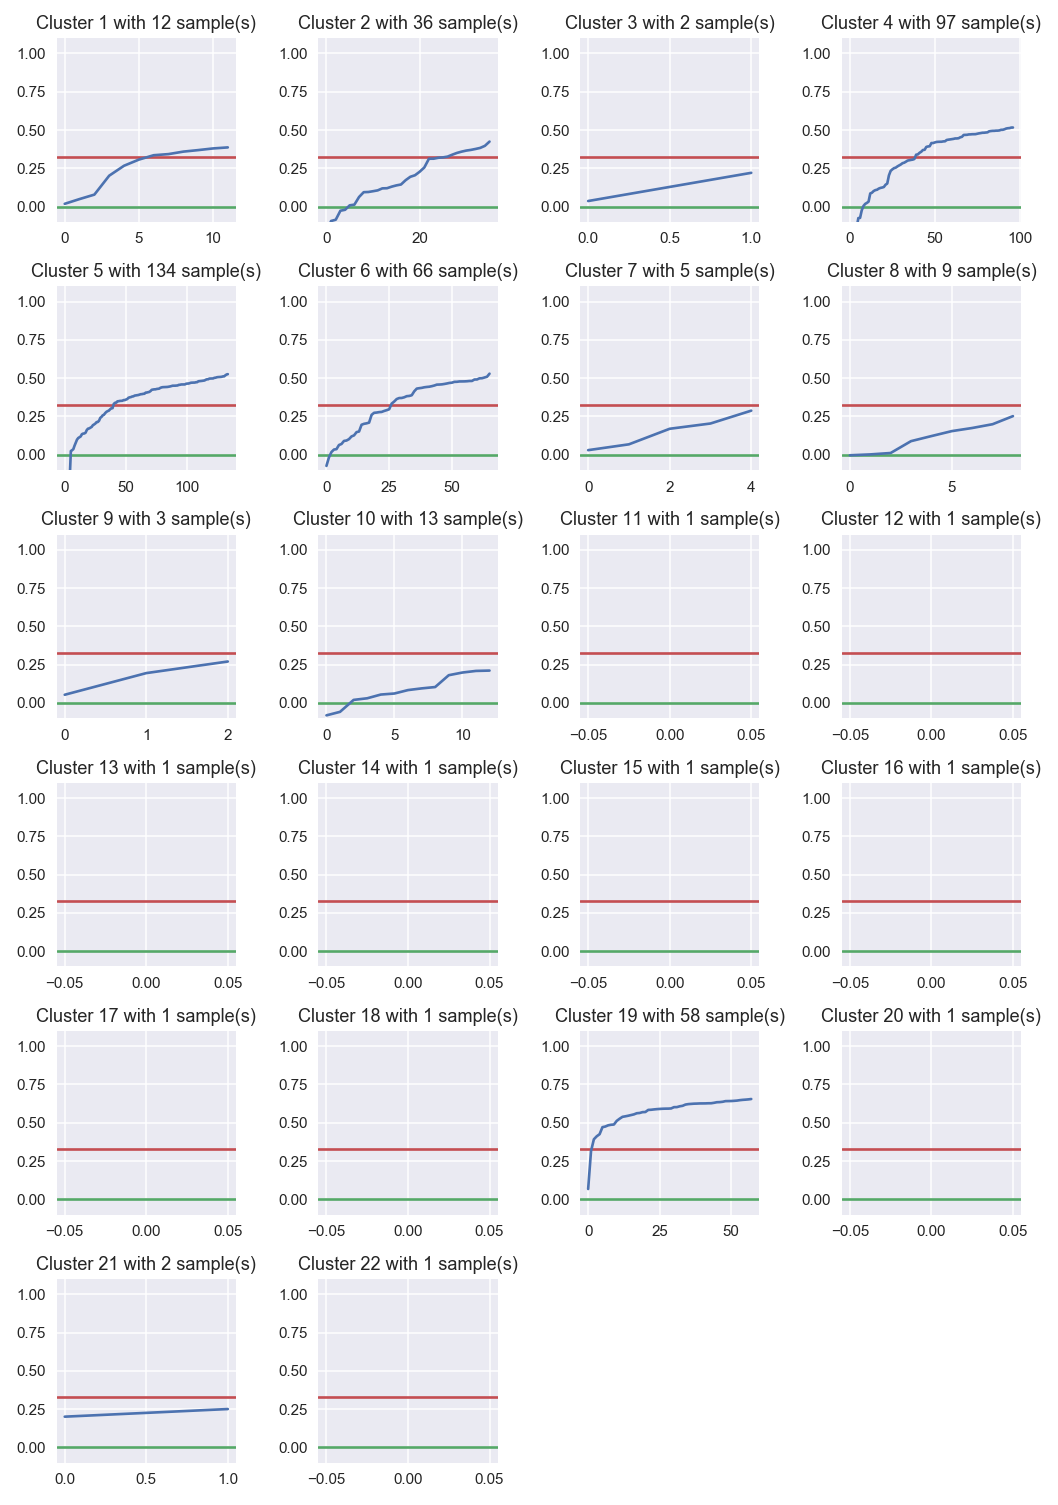

In [32]:
agg_clst = cluster.AgglomerativeClustering(n_clusters=n_clust,
                                           affinity='precomputed',
                                           linkage='average').fit(np.square(dist_mat))

sample_scores = metrics.silhouette_samples(dist_mat, agg_clst.labels_, metric='precomputed')
avg_score = metrics.silhouette_score(dist_mat, agg_clst.labels_, metric='precomputed')
score.append(avg_score)

fig, ax = plt.subplots(num='Average Silhouette Scores up to ' + str(n_clust) + ' Clusters', figsize=(9.7, 3.5))
ax.plot(score);

fig = plt.figure(num='Average Silhouette Score ' + str(avg_score) +
                     ' for ' + str(n_clust) + ' Clusters', figsize=(9.7, 2.3*(((n_clust - 1) // 4) + 1)))

for i_clust in range(n_clust):
    cluster_i = sample_scores[agg_clst.labels_ == i_clust]
    cluster_i.sort()
    
    ax = fig.add_subplot(((n_clust - 1) // 4) + 1, 4, i_clust + 1)
    
    ax.set_ylim(bottom=-0.1, top=1.1)
    ax.axhline(y=avg_score, color='#c44e52')
    ax.axhline(y=0.0, color='#55a868')
    ax.plot(cluster_i)
    ax.set_title('Cluster ' + str(i_clust + 1) + ' with ' + str(len(cluster_i)) + ' sample(s)')

fig.tight_layout()    

n_clust += 1

#### SOME GOOD SETTINGS FOR AGGLOMERATIVE CLUSTERING:
* __Apparently best results with 'complete'__: 12 clusters (avg. score 0.32, max. score 0.7) with _any_ distance
* __Apparently best results with 'average'__: 19 clusters (avg. score 0.33, max. score 0.7) with _normal_ distance
* __Apparently best results with 'average'__: 22 clusters (avg. score 0.35, max. score 0.7) with _normal_ distance
* __Apparently best results with 'average'__: 21 clusters (avg. score 0.35, max. score 0.7) with _squared_ distance

#### 4-5 Clusters of appreciable size are found!

### OPTION 2: Affinity Popagation
Try increasing the _pref_ value below. A minimum of -1500 for the _squared_ distance and an minimum of -110 for the _normal_ distance seem to be good starting values here. _Squared_ and _normal_ refer to the argument of the _fit_ method of the _AffinityPropagation_ class in the two cells below.

When you execute the cell below, you will get a list. Set the _damp_ value on the last line of the cell to the minimum, from where the number of clusters does not change anymore.

In [36]:
pref = -110  # Try increasing the value from its minimum

score = []
n_clust = []

for damp in np.linspace(0.5, 1.0, 10, endpoint=False):
    aff_prop = cluster.AffinityPropagation(damping=damp,
                                           preference=pref,
                                           affinity='precomputed').fit(-dist_mat)
    
    score.append(metrics.silhouette_score(dist_mat, aff_prop.labels_, metric='precomputed'))
    n_clust.append(aff_prop.labels_.max() + 1)

print(pd.DataFrame([score, n_clust], 
                   columns=np.linspace(0.5, 1.0, 10, endpoint=False), 
                   index=('Silhouette', 'n_clust')).T)

damp = 0.55  # Chose a value where the number of clusters does not change anymore when you make it larger

      Silhouette  n_clust
0.50    0.054535    229.0
0.55    0.357451      4.0
0.60    0.357451      4.0
0.65    0.357451      4.0
0.70    0.357451      4.0
0.75    0.357451      4.0
0.80    0.357451      4.0
0.85    0.357451      4.0
0.90    0.357451      4.0
0.95    0.357451      4.0


#### Repeatedly executing the cell below increases damping consecutively. Examine the results!

<IPython.core.display.Javascript object>


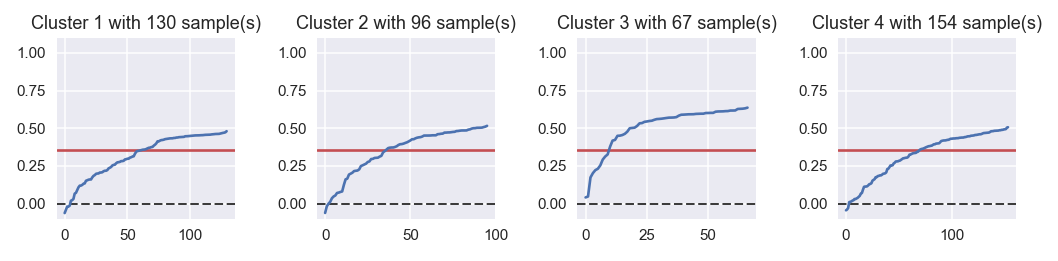

In [38]:
aff_prop = cluster.AffinityPropagation(damping=damp,
                                       preference=pref,
                                       affinity='precomputed').fit(-dist_mat)
    
sample_scores = metrics.silhouette_samples(dist_mat, aff_prop.labels_, metric='precomputed')
avg_score = metrics.silhouette_score(dist_mat, aff_prop.labels_, metric='precomputed')
n_clust = aff_prop.labels_.max() + 1

fig = plt.figure(num='Average Silhouette Score ' + str(avg_score) +
                     ' for ' + str(n_clust) + ' Clusters and ' +
                     ' damp = ' + str(damp), figsize=(9.7, 2.4*(((n_clust - 1) // 4) + 1)))

for i_clust in range(n_clust):
    cluster_i = sample_scores[aff_prop.labels_ == i_clust]
    cluster_i.sort()
    
    ax = fig.add_subplot(((n_clust - 1) // 4) + 1, 4, i_clust + 1)
    
    ax.set_ylim(bottom=-0.1, top=1.1)
    ax.axhline(y=avg_score, color='#c44e52')
    ax.axhline(y=0.0, color='k', linestyle='--', linewidth=1.0)
    ax.plot(cluster_i)
    ax.set_title('Cluster ' + str(i_clust + 1) + ' with ' + str(len(cluster_i)) + ' sample(s)')

fig.tight_layout()    

if damp < 0.95:
    damp += 0.05

#### SOME GOOD SETTINGS FOR AFFINITY PROPAGATION:
* __pref = -1200, damp = 0.9__, 4 clusters (avg. score 0.36, max. score 0.6) for _squared_ distance
* __pref = -300, damp = any__, 5 clusters (avg. score 0.34, max. score 0.6) for _squared_ distance
* __pref = -300, damp = 0.7__, 6 clusters (avg. score 0.36, max. score 0.6) for _squared_ distance
* __pref = -100, damp = any__, 4 clusters (avg. score 0.36, max. score 0.6) for _normal_ distance
* __pref = -50, damp = any__, 5 clusters (avg. score 0.34, max. score 0.6) for _normal_ distance

#### 4-6 Clusters of appreciable size are found!

### OPTION 3: DBSCAN
Try playing around with the two parameters _epsilon_ and *min_samp* until you get a reasonable number of clusters and not too many noisy samples!

In [42]:
epsilon = 2.45
min_samp = 47

db_scan = cluster.DBSCAN(eps=epsilon, 
                         min_samples=min_samp, 
                         metric='precomputed').fit(dist_mat)

print('Number of Clusters: ' + str(db_scan.labels_.max() + 1))
print('Number of Noisy Samples: ' + str(db_scan.labels_[db_scan.labels_ == -1].size))

Number of Clusters: 4
Number of Noisy Samples: 138


#### Repeatedly executing the cell below increases epsilon consecutively. Examine the results!

<IPython.core.display.Javascript object>


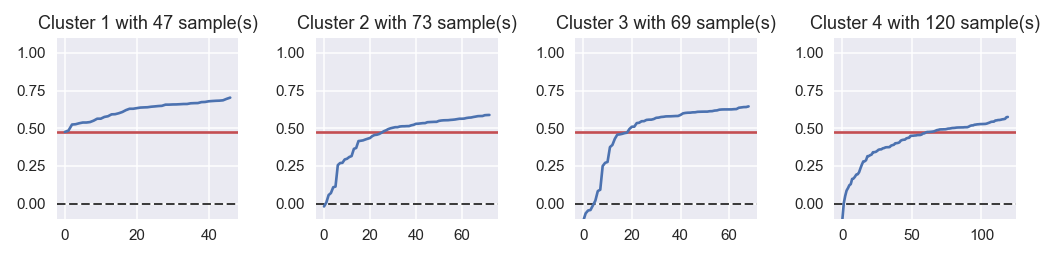

In [43]:
db_scan = cluster.DBSCAN(eps=epsilon, 
                         min_samples=min_samp, 
                         metric='precomputed').fit(dist_mat)

sample_scores = metrics.silhouette_samples(dist_mat, db_scan.labels_, metric='precomputed')
avg_score = sample_scores[db_scan.labels_ > -1].sum() /  db_scan.labels_[db_scan.labels_ > -1].size
n_clust = db_scan.labels_.max() + 1
n_noisy = db_scan.labels_[db_scan.labels_ == -1].size

fig = plt.figure(num='Average Silhouette Score ' + str(avg_score) +
                     ' for ' + str(n_clust) + ' Clusters, ' + str(n_noisy) + ' noisy samples, and ' +
                     ' eps = ' + str(epsilon), figsize=(9.7, 2.4*(((n_clust - 1) // 4) + 1)))

for i_clust in range(n_clust):
    cluster_i = sample_scores[db_scan.labels_ == i_clust]
    cluster_i.sort()
    
    ax = fig.add_subplot(((n_clust - 1) // 4) + 1, 4, i_clust + 1)
    
    ax.set_ylim(bottom=-0.1, top=1.1)
    ax.axhline(y=avg_score, color='#c44e52')
    ax.axhline(y=0.0, color='k', linestyle='--', linewidth=1.0)
    ax.plot(cluster_i)
    ax.set_title('Cluster ' + str(i_clust + 1) + ' with ' + str(len(cluster_i)) + ' sample(s)')

fig.tight_layout()
    
epsilon = epsilon + 0.1

#### SOME GOOD SETTINGS FOR DBSCAN:
* __Apparently best results with eps=1.43, min_samp=7__:   4 clusters (avg. score 0.62, max. score 0.8) with 242 noisy samples
* __Apparently best results with eps=1.55, min_samp=8__:   4 clusters (avg. score 0.59, max. score 0.8) with 214 noisy samples
* __Apparently best results with eps=1.61, min_samp=9__:   4 clusters (avg. score 0.57, max. score 0.8) with 198 noisy samples
* __Apparently best results with eps=1.62, min_samp=10__:   4 clusters (avg. score 0.55, max. score 0.8) with 195 noisy samples
* __Apparently best results with eps=1.87, min_samp=15__:   4 clusters (avg. score 0.52, max. score 0.8) with 166 noisy samples
* __Apparently best results with eps=2.06, min_samp=20__:   4 clusters (avg. score 0.49, max. score 0.7) with 144 noisy samples
* __Apparently best results with eps=2.21, min_samp=30__:   4 clusters (avg. score 0.49, max. score 0.7) with 140 noisy samples
* __Apparently best results with eps=2.37, min_samp=40__:   4 clusters (avg. score 0.48, max. score 0.7) with 135 noisy samples
* __Apparently best results with eps=2.45, min_samp=47__:   4 clusters (avg. score 0.48, max. score 0.6) with 138 noisy samples

#### 4 Clusters of appreciable size are found!

## Visualize Results

### Pick the clustering method from which to plot the results

In [44]:
method = aff_prop  # choices are 'aff_prop', db_scan', or 'agg_clst'

results = pd.DataFrame(data=method.labels_, index=data.index.levels[0], columns=['cluster'])
results['distance'] = np.zeros(results.shape[0])

n_clust = results.cluster.max() + 1

#### NOT FOR _AGGLOMERATIVE CLUSTERING_: Compute distance between cluster members and respective cluster means

In [45]:
max_dist = 0

for i_clust in range(n_clust):    
    index_list = results[results.cluster == i_clust].index.tolist()
    clust_mean = data.loc[index_list].mean(level=1)
    for lor in index_list:
        results.loc[lor, 'distance'] = distanceL2(data.loc[lor], clust_mean, measure)
    if (results.distance.loc[index_list].max() > max_dist):
        max_dist = results.distance.loc[index_list].max()

results = results.apply(lambda x: x / (1, max_dist), axis=1)
results.cluster = results.cluster.astype(int)

del max_dist
del clust_mean

### Plot results onto Berlin map

<IPython.core.display.Javascript object>


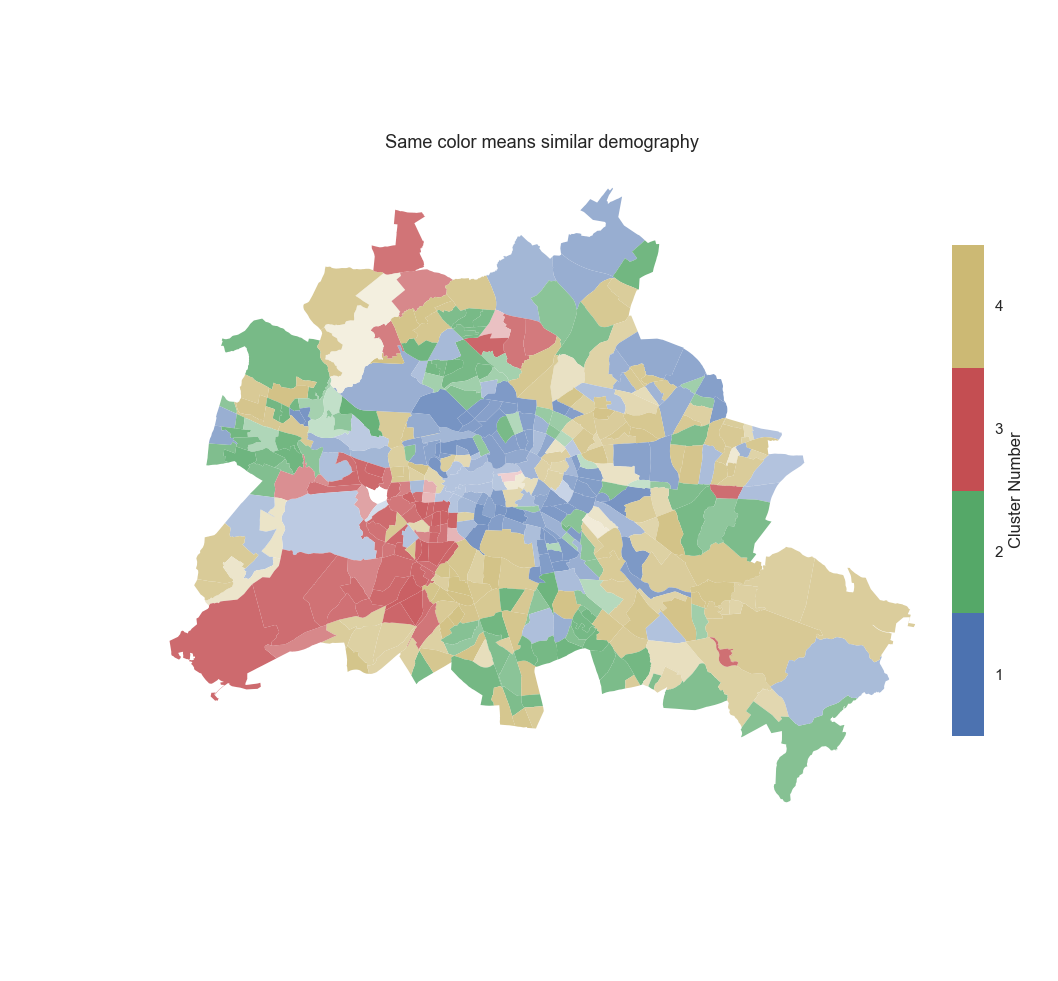

In [49]:
sbn_cmap = sbn.color_palette(n_colors=n_clust+1) # Define the final list
sbn_cmap.remove(sbn.color_palette()[3])          # of colors to use here!
cbar_cmap = ListedColormap(sbn_cmap)
cmaps = []
for i_clust in range(n_clust):
    cmaps.append(LinearSegmentedColormap.from_list('Cluster'+str(i_clust), ('white', sbn_cmap[i_clust])))
cmaps.append(LinearSegmentedColormap.from_list('NoCluster', ('white','white')))
    
fig, ax = plt.subplots(num='Map of the Similarity in Population', figsize=(9.7, 9))

for lor in lors.iterShapeRecords():
    i_clust = results.loc[int(lor.record[0])].cluster.astype(int)
    cmap = cmaps[i_clust]
    distance = 1.0 - results.loc[int(lor.record[0])].distance
    polygon = Polygon(lor.shape.points,
                      fill=True,
                      facecolor=cmap(distance),
                      alpha = 1.0)
    ax.add_patch(polygon)

ax.axis('auto');
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('Same color means similar demography')
ax.set_facecolor('white')

tickpositions = np.linspace(0.5/n_clust, 1.0 - 0.5/n_clust, n_clust).tolist()
ticklabels = list(range(1, n_clust + 1))

cax = fig.add_axes([0.90, 0.25, 0.03, 0.50])
cbar = ColorbarBase(cax, cmap=cbar_cmap, label='Cluster Number', ticks=tickpositions)
cbar.set_ticklabels(ticklabels)

### Inspect category means in clusters
Inspect the difference between clusters in one of the categories chosen by the first variable in the cell below.

<IPython.core.display.Javascript object>


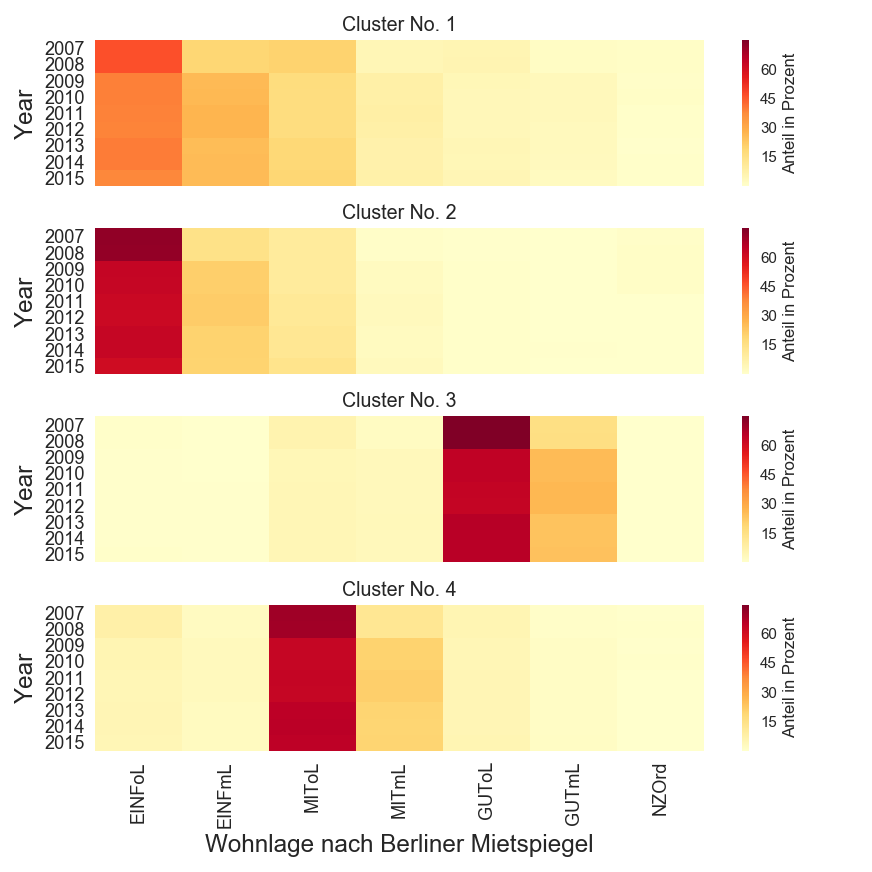

In [51]:
category = 'typ'  # Choices are: age, sex, typ, dur, org

cat_lab = {'age': 'Alter in Jahren',
           'sex': 'Geschlecht m/w',
           'typ': 'Wohnlage nach Berliner Mietspiegel',
           'dur': 'Wohndauer in Jahren',
           'org': 'Migrationshintergrund'}

vmax = l1_norm_dat[category].mean(level=1).values.min() * 100.0
vmin = l1_norm_dat[category].mean(level=1).values.max() * 100.0

for i_clust in range(n_clust):
    index_list = results[results.cluster == i_clust].index.tolist()    
    comp_max = l1_norm_dat.loc[index_list, category].mean(level=1).values.max() * 100.0
    comp_min = l1_norm_dat.loc[index_list, category].mean(level=1).values.min() * 100.0    
    if comp_max > vmax:
        vmax = comp_max
    if comp_min < vmin:
        vmin = comp_min

fig = plt.figure(num='Compare Clusters in Category "' + (category) + '"', figsize=(8, 2.0*n_clust))

for i_clust in range(n_clust):
    index_list = results[results.cluster == i_clust].index.tolist()
    disp_data = l1_norm_dat.loc[index_list, category].mean(level=1) * 100.0
    
    ax = fig.add_subplot(n_clust, 1, i_clust + 1)
    ax.set_title('Cluster No. ' + str(i_clust + 1), fontsize=13)
    
    plot = sbn.heatmap(disp_data, vmin=vmin, vmax=vmax, ax=ax, cmap='YlOrRd', cbar_kws={'label':'Anteil in Prozent'})
    plot.set_xticklabels('')
    plot.set_yticklabels(plot.get_ymajorticklabels(), rotation=0, fontsize=12)
    plot.set_ylabel(plot.get_ylabel(), fontsize=16)

plot.set_xticklabels(plot.get_xmajorticklabels(), rotation=90, fontsize=12)
plot.set_xlabel(cat_lab[category], fontsize=16)
fig.tight_layout()

### Inspect characteristics of each cluster
Chose German (_Ger_) or English (_Eng_) labels by the first variable defined in the cell below!

In [52]:
lang = 'Eng'  # Choose language here

if lang == 'Eng':
    org_labels = ['German', 'EU-15', 'EU-East', 'Polish', 'Fmr. Jug', 'Fmr. SU', 'Turkish', 'Arab', 'Other', 'N.A.']
    typ_labels = ['Low | quiet', 'Low | noisy', 'Mid | quiet', 'Mid | noisy', 'Hi | quiet', 'Hi | noisy', 'N.A.']
else:
    org_labels = data.org.columns
    typ_labels = data.typ.columns

#### Actual plotting
Chose the number of the cluster you want to inspect by the first variable defined in the cell below (starting with 0)!

<IPython.core.display.Javascript object>


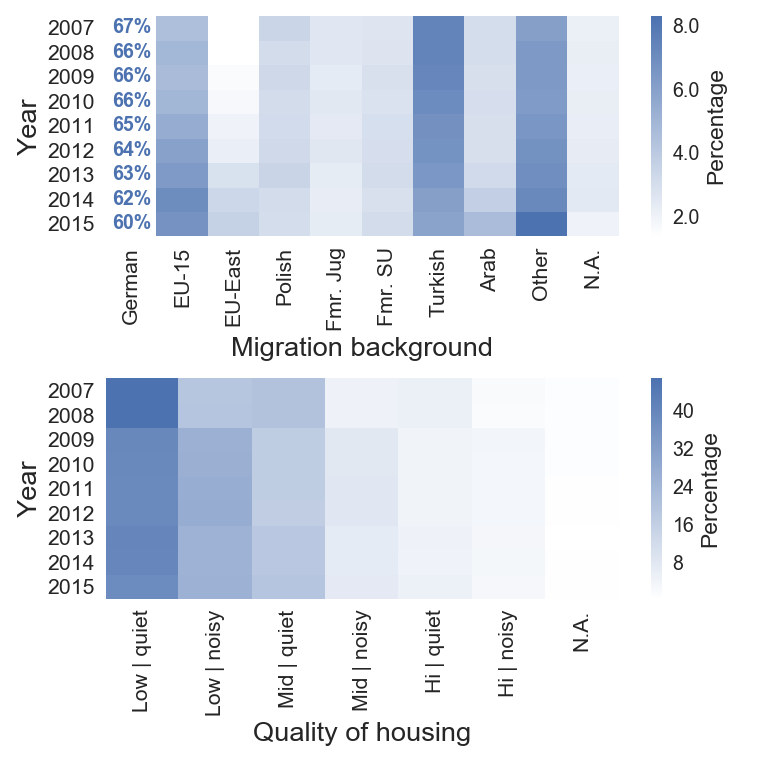

In [53]:
i_clust = 0  # Chose cluster number to visuaize here

index_list = results[results.cluster == i_clust].index.tolist()

typ_mean = l1_norm_dat.loc[index_list, 'typ'].mean(level=1) * 100.0
org_mean = l1_norm_dat.loc[index_list, 'org'].mean(level=1) * 100.0
de__mean = de_norm_org.loc[index_list       ].mean(level=1) * 100.0

org_mean.De = org_mean.drop('De', axis=1).min().min()

annot = pd.DataFrame(np.zeros(org_mean.shape))
annot[:] = ''
annot.loc[:,0] = np.around(de__mean).astype(int).apply(lambda x: str(x) + '%').values

fig = plt.figure(num='Characteristics of Cluster ' + str(i_clust), figsize=(7, 7))
org_ax = fig.add_subplot(211)
typ_ax = fig.add_subplot(212)

org_plot = sbn.heatmap(org_mean,
                       ax=org_ax,
                       annot=annot,
                       annot_kws={'color':cmaps[i_clust](1.0), 'weight':'bold', 'size':13},
                       fmt='',
                       cmap=cmaps[i_clust])
org_cbar = org_plot.collections[0].colorbar
org_plot.set_xticklabels(org_labels,                      fontsize=14, rotation=90)
org_plot.set_yticklabels(org_plot.get_ymajorticklabels(), fontsize=14, rotation=0 )
org_plot.set_xlabel('Migration background', fontsize=18)
org_plot.set_ylabel(org_plot.get_ylabel(),  fontsize=18)
org_cbar.set_label('Percentage', size=15)

lims = org_cbar.get_clim()
vmin, vmax = np.ceil(lims[0]), np.floor(lims[1])
ticks = np.linspace(vmin, vmax, 4)

org_cbar.set_ticks(ticks)
org_cbar.ax.tick_params(labelsize=13)
org_cbar.set_ticklabels(['%.1f' % x for x in ticks])

typ_plot = sbn.heatmap(typ_mean, ax=typ_ax, cmap=cmaps[i_clust], cbar_kws={'label':'Percentage'})
typ_cbar = typ_plot.collections[0].colorbar
typ_plot.set_xticklabels(typ_labels,                      fontsize=14, rotation=90)
typ_plot.set_yticklabels(typ_plot.get_ymajorticklabels(), fontsize=14, rotation=0 )
typ_plot.set_xlabel('Quality of housing',    fontsize=18)
typ_plot.set_ylabel(typ_plot.get_ylabel(),     fontsize=18)
typ_cbar.set_label('Percentage', size=15)
typ_cbar.ax.tick_params(labelsize=13)

fig.tight_layout()
sbn.set()

### Export clustering results to CSV

In [54]:
string_index = []

for lor in lors.iterShapeRecords():
    string_index.append(lor.record[0])
    
results.index = string_index
results.index.name = 'plr'
results.to_csv('./gentrified.csv')

del string_index